# Blight Violation Classification

A classifier which predicts whether a blight violation will be paid on time**

In [1]:
import numpy as np
import pandas as pd

In [2]:
#Import blight violation data for the City of Detroit as DataFrame from 
#https://data.detroitmi.gov/Property-Parcels/Blight-Violations/ti6p-wcg4/data
data = pd.read_csv("Blight_violations.csv", index_col="Ticket ID")

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8,9,13,14,15,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preprocessing

In [3]:
#store names of available columns for future reference
dataColumns = list(data.columns)

In [4]:
#PREPROCESSING: first round of cleaning up data
#filling NaN's for simple cases of missing values
data["Payment Amount (Sum of All Payments)"].fillna(0, inplace=True)
data["Clean Up Cost"].fillna(0, inplace=True)
data["Mailing Address Non-USA Code"].fillna("Not Available", inplace=True)
data["Mailing Address Country"].fillna("United States of America", inplace=True)
data["Mailing Address City"].fillna("Non-USA", inplace=True)
data["Mailing Address State"].fillna("Non-USA", inplace=True)
data["Mailing Address Zip Code"].fillna("Non-USA", inplace=True)
data["Disposition"].fillna("Unknown/Not Recorded", inplace=True)
data["Hardest Hit Fund Areas"].fillna(0, inplace=True)
data["Payment Status"].fillna("PAYMENT NOT RECIEVED", inplace=True)
data["Collection Status"].fillna("Unknown/Not Recorded", inplace=True)   

In [5]:
#Classify Mailing Address Cities into ('Detroit' and 'Not Detroit')
data['Mailing Address City'][data['Mailing Address City'].str.upper() == 'DETROIT'] = 'Detroit'
data['Mailing Address City'][data['Mailing Address City'].str.upper() != 'DETROIT'] = 'Not Detroit'

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
#remove rows where no payment was required
data = data[data["Judgment Amount (Total Due)"] > 0]

In [7]:
#Preliminary features to be used for classifier
quantitative_feature_names = ["Fine Amount", "Admin Fee", "State Fee", "Discount Amount", "Clean Up Cost", "Judgment Amount (Total Due)"]
categorical_feature_names = ["Violation Street Name", "Mailing Address City","Mailing Address State", "Mailing Address Country"] 
#process times into categories of morning, afternoon, night
#perhaps simplify Countries, States into groups?

In [8]:
#drop rows with NaN's in pertinent columns
data = data.dropna(subset=quantitative_feature_names + categorical_feature_names + ["Balance Due"])

In [9]:
data.head()

,Ticket Number,Agency Name,Inspector Name,Violator Name,Violator ID,Violation Street Number,Violation Street Name,Violation Zip Code,Mailing Address Street Number,Mailing Address Street Name,...,Violation Parcel ID,Violation Latitude,Violation Longitude,Violation Location,Zip Codes,Counties,Scout Car Areas,Detroit Neighborhoods,City Council Districts,Hardest Hit Fund Areas
Ticket ID,,,,,,,,,,,,,,,,,,,,,
369851,16018555DAH,Department of Public Works,Valentina Johnson,KENNETH AND JEAN LEONARD,336308,6100,IRONWOOD,48210,71,TYLER,...,16011692.,42.349161,-83.120844,"location\n(42.349161198904, -83.120843716505)",7314.0,1345.0,81.0,133.0,5.0,0.0
445182,18030933DAH,Department of Public Works,Devlin Brown,SUNDUS WARDA,411638,541,ADELINE ST,48203,22681,WOODWARD,...,01007752.,42.438384,-83.110144,"location\n(42.43838, -83.11014)",14767.0,1345.0,82.0,69.0,2.0,0.0
461571,19029777DAH,"Buildings, Safety Engineering & Env Department",Ronald Aubert,"HALL EQUITIES, LLC",428027,20276,PIERSON,48219,7145,OAKWOOD,...,22106729.011,42.441340,-83.247497,"location\n(42.44134, -83.2475)",19613.0,1345.0,131.0,180.0,1.0,2.0
461574,19029779DAH,"Buildings, Safety Engineering & Env Department",Ronald Aubert,"HALL EQUITIES, LLC",428030,20276,PIERSON,48219,7145,OAKWOOD,...,22106729.011,42.441340,-83.247497,"location\n(42.44134, -83.2475)",19613.0,1345.0,131.0,180.0,1.0,2.0
461572,19029778DAH,"Buildings, Safety Engineering & Env Department",Ronald Aubert,"HALL EQUITIES, LLC",428028,20276,PIERSON,48219,7145,OAKWOOD,...,22106729.011,42.441340,-83.247497,"location\n(42.44134, -83.2475)",19613.0,1345.0,131.0,180.0,1.0,2.0


In [10]:
#remove outliers from quantitative features
#an outlier is taken to be any row with at least one column value at least 3 standard deviations away from the mean
from scipy import stats
data = data[(np.abs(stats.zscore(data[quantitative_feature_names])) < 3).all(axis=1)];

In [11]:
#Extract quantitative and qualitative features
quantitativeFeatures = data[quantitative_feature_names]
categoricalFeatures = data[categorical_feature_names]

In [12]:
#Convert categorical features into a series of binary features
categoricalFeatures = pd.get_dummies(categoricalFeatures)

In [13]:
#rejoin features
features = quantitativeFeatures.join(categoricalFeatures)
featureColumns = features.columns

In [14]:
features.head()

,Fine Amount,Admin Fee,State Fee,Discount Amount,Clean Up Cost,Judgment Amount (Total Due),Violation Street Name_10TH ST,Violation Street Name_10TH ST,Violation Street Name_11TH ST,Violation Street Name_14TH ST,...,Mailing Address Country_Switzerland,Mailing Address Country_Taiwan,Mailing Address Country_Thailand,Mailing Address Country_Tokelau,Mailing Address Country_Ukraine,Mailing Address Country_United Arab Emirates,Mailing Address Country_United Kingdom,Mailing Address Country_United States of America,Mailing Address Country_Vietnam,Mailing Address Country_Virgin Islands
Ticket ID,,,,,,,,,,,,,,,,,,,,,
369851,50.0,20.0,10.0,0.0,0.0,80.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
445182,100.0,20.0,10.0,0.0,0.0,130.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
461571,250.0,20.0,10.0,0.0,0.0,280.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
461574,250.0,20.0,10.0,0.0,0.0,280.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
461572,500.0,20.0,10.0,0.0,0.0,530.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [15]:
#PREPROCESSING: normalization of ranges of features into [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(features)
transformedFeatures = pd.DataFrame(scaler.transform(features), columns = featureColumns)

In [16]:
#Extract labels
labels = pd.DataFrame(data["Balance Due"] > 0).rename(columns={"Balance Due": "Payment OverDue"})

In [17]:
labels.head()

,Payment OverDue
Ticket ID,
369851,True
445182,True
461571,True
461574,True
461572,True


## Pre-Training Data Visualization

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

First, extract a sample from the data with balanced class distribution for visualization  

In [19]:
labelDict = {True: 'Non-Compliance', False: 'Compliance'}

In [20]:
from imblearn.under_sampling import RandomUnderSampler

C:\Users\awnya\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [21]:
rus = RandomUnderSampler(sampling_strategy=1) #sample data with balanced distribution of classes (1:1)
features_, labels_ = rus.fit_resample(transformedFeatures[:30000], labels[:30000])

In [22]:
data_ = pd.DataFrame(features_[:,:2016], columns=features.columns)
data_['Status'] = [labelDict[x[0]] for x in labels_]

In [23]:
len(data_)

10976

In [24]:
data_.head()

,Fine Amount,Admin Fee,State Fee,Discount Amount,Clean Up Cost,Judgment Amount (Total Due),Violation Street Name_10TH ST,Violation Street Name_10TH ST,Violation Street Name_11TH ST,Violation Street Name_14TH ST,...,Mailing Address Country_Taiwan,Mailing Address Country_Thailand,Mailing Address Country_Tokelau,Mailing Address Country_Ukraine,Mailing Address Country_United Arab Emirates,Mailing Address Country_United Kingdom,Mailing Address Country_United States of America,Mailing Address Country_Vietnam,Mailing Address Country_Virgin Islands,Status
0,0.249625,1.0,1.0,0.0,0.0,0.249625,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Compliance
1,0.049525,1.0,1.0,0.0,0.0,0.049525,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Compliance
2,0.099550,1.0,1.0,0.8,0.0,0.089545,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Compliance
3,0.124562,1.0,1.0,0.0,0.0,0.124562,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Compliance
4,0.124562,1.0,1.0,1.0,0.0,0.112056,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Compliance


### Parallel Coordinates Plot 

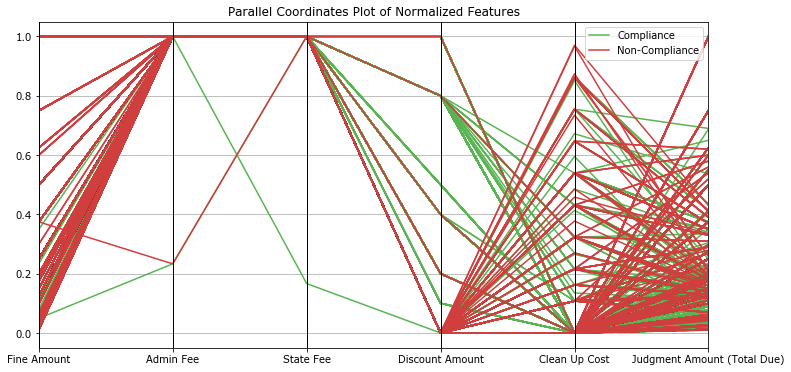

In [25]:
fig = plt.figure()
fig.set_size_inches(12, 6)
testFeatures = ['Fine Amount', 'Admin Fee', 'State Fee', 'Discount Amount', 'Clean Up Cost', 'Judgment Amount (Total Due)']
pd.plotting.parallel_coordinates(data_, 'Status', cols=testFeatures, color=['#58b551','#d13e3e']);
plt.title('Parallel Coordinates Plot of Normalized Features')
plt.savefig('Parallel_Coordinates_Plot.png', dpi=200)

### Pairs Plot 

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


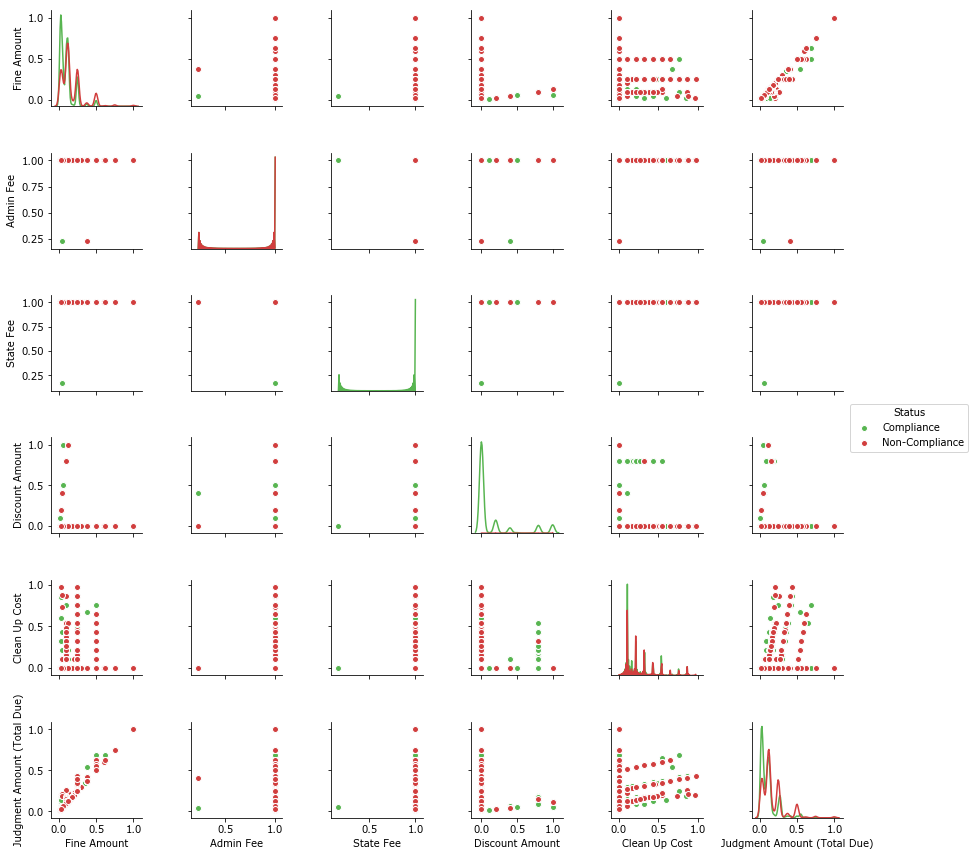

In [26]:
pairGrid = sns.pairplot(data_, hue='Status', diag_kind='kde', size=2, vars=testFeatures, palette=['#58b551','#d13e3e']);

In [27]:
pairGrid.savefig('Pair_Plot.png', dpi=200)

### Point Plots: represent an estimate of central tendency for a numeric variable with indication of uncertainty

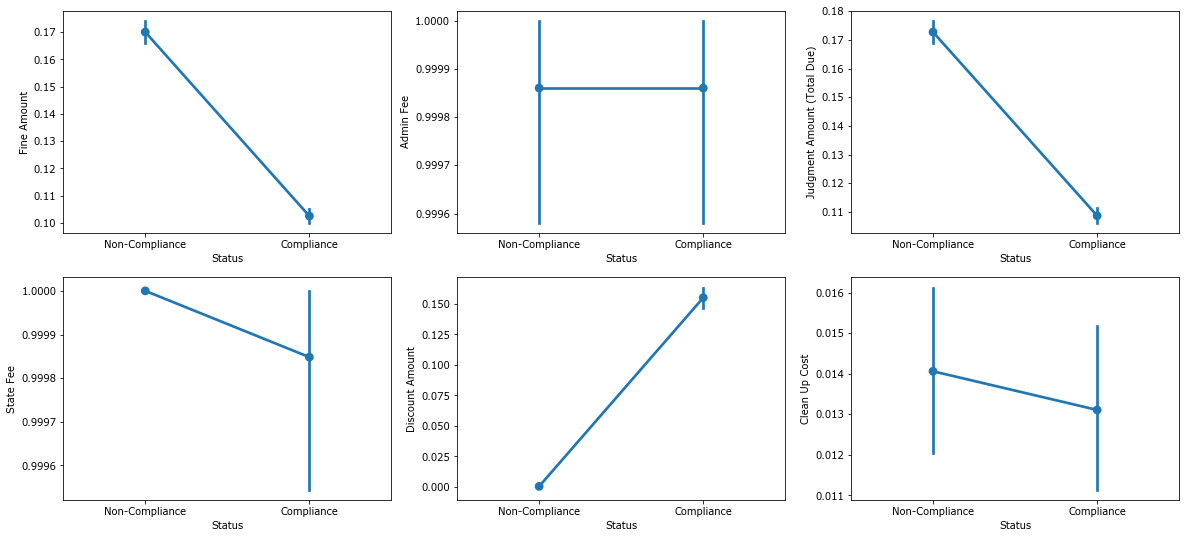

In [28]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3)
fig.set_size_inches(20, 9)

sns.pointplot(x="Status", y="Fine Amount", data=data_, order=['Non-Compliance', 'Compliance'], ax=ax1)
sns.pointplot(x="Status", y="Admin Fee", data=data_, order=['Non-Compliance', 'Compliance'], ax=ax2)
sns.pointplot(x="Status", y="Judgment Amount (Total Due)", data=data_, order=['Non-Compliance', 'Compliance'], ax=ax3)

sns.pointplot(x="Status", y="State Fee", data=data_, order=['Non-Compliance', 'Compliance'], ax=ax4)
sns.pointplot(x="Status", y="Discount Amount", data=data_, order=['Non-Compliance', 'Compliance'], ax=ax5)
sns.pointplot(x="Status", y="Clean Up Cost", data=data_, order=['Non-Compliance', 'Compliance'], ax=ax6)

fig.savefig('Point_Plot_Grid.png', dpi=200)

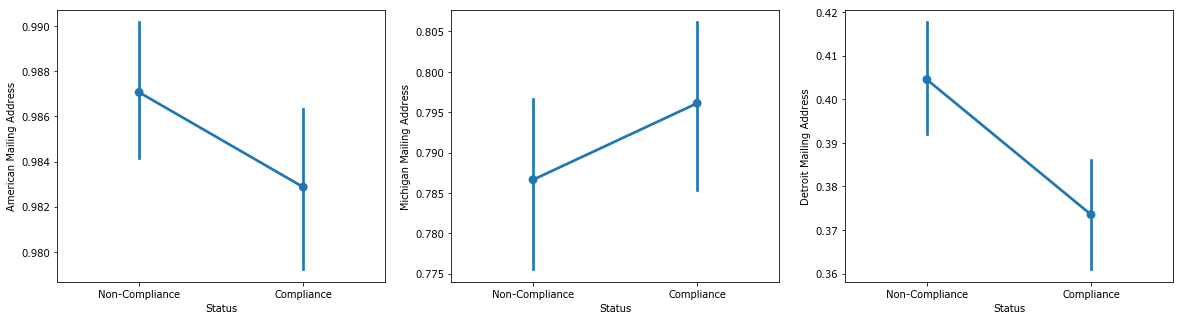

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(20, 5)

sns.pointplot(x="Status", y="Mailing Address Country_United States of America", data=data_, order=['Non-Compliance', 'Compliance'], ax=ax1)
sns.pointplot(x="Status", y="Mailing Address State_MI", data=data_, order=['Non-Compliance', 'Compliance'], ax=ax2)
sns.pointplot(x="Status", y="Mailing Address City_Detroit", data=data_, order=['Non-Compliance', 'Compliance'], ax=ax3)


ax1.set_ylabel('American Mailing Address')
ax2.set_ylabel('Michigan Mailing Address')
ax3.set_ylabel('Detroit Mailing Address')

fig.savefig('Mailing Address Point Plot')

### Violin Plots 

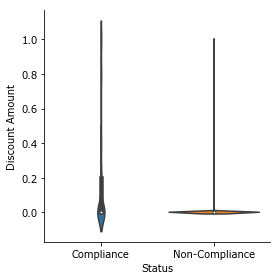

In [30]:
data_["Discount Amount"] = data_["Discount Amount"].astype(float)
violinDiscount = sns.factorplot(x="Status", y="Discount Amount", data=data_, kind='violin')
violinDiscount.savefig('Discount_Violin.png', dpi=200)

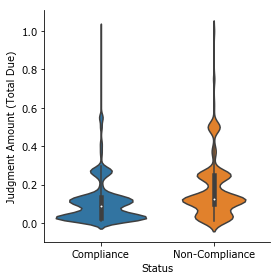

In [31]:
data_["Judgment Amount (Total Due)"] = data_["Judgment Amount (Total Due)"].astype(float)
violinDiscount = sns.factorplot(x="Status", y="Judgment Amount (Total Due)", data=data_, kind='violin')
violinDiscount.savefig('Judgment_Violin.png', dpi=200)

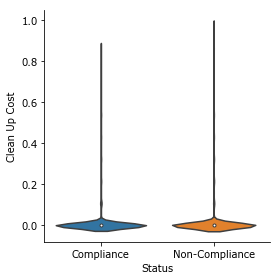

In [32]:
data_["Clean Up Cost"] = data_["Clean Up Cost"].astype(float)
violinDiscount = sns.factorplot(x="Status", y="Clean Up Cost", data=data_, kind='violin')
violinDiscount.savefig('CleanUpCost_Violin.png', dpi=200)

# Classification

In [33]:
#split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.35, random_state=0)

## Decision Tree 

### Train Decision Tree Classifier 

In [34]:
from sklearn.tree import DecisionTreeClassifier
DTClf = DecisionTreeClassifier(random_state=0, min_impurity_decrease=0.0001)

In [35]:
DTClf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0001, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [36]:
#Make predictions
pred = DTClf.predict(X_test)

### Classification Report 

In [37]:
from sklearn.metrics import classification_report
classificationReportDT = classification_report(y_test, pred)

print(classificationReportDT)

              precision    recall  f1-score   support

       False       0.94      0.75      0.83     23298
        True       0.92      0.98      0.95     68015

    accuracy                           0.92     91313
   macro avg       0.93      0.87      0.89     91313
weighted avg       0.93      0.92      0.92     91313



### Confusion Matrix 

In [38]:
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(y_test, pred)
print(confusionMatrix)

[[17489  5809]
 [ 1115 66900]]


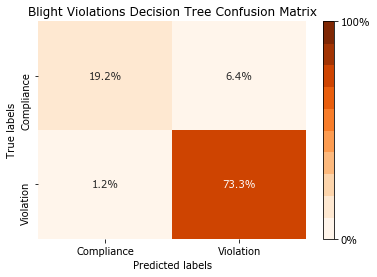

In [39]:
#PLOT CONFUSION MATRIX
from matplotlib import cm
fig, ax = plt.subplots()
sns.heatmap(confusionMatrix / np.sum(confusionMatrix), annot=True, fmt='.1%', ax = ax, cbar=False, vmin=0, vmax=1, cmap=cm.get_cmap('Oranges', 10)); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Blight Violations Decision Tree Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Compliance', 'Violation']); 
ax.yaxis.set_ticklabels(['Compliance', 'Violation']);

cbar = ax.figure.colorbar(ax.collections[0]);
cbar.set_ticks([0, 1]);
cbar.set_ticklabels(["0%", "100%"]);

fig.savefig('Confusion_Matrix_DT.png', dpi=200)

### Decision Tree Visualization 

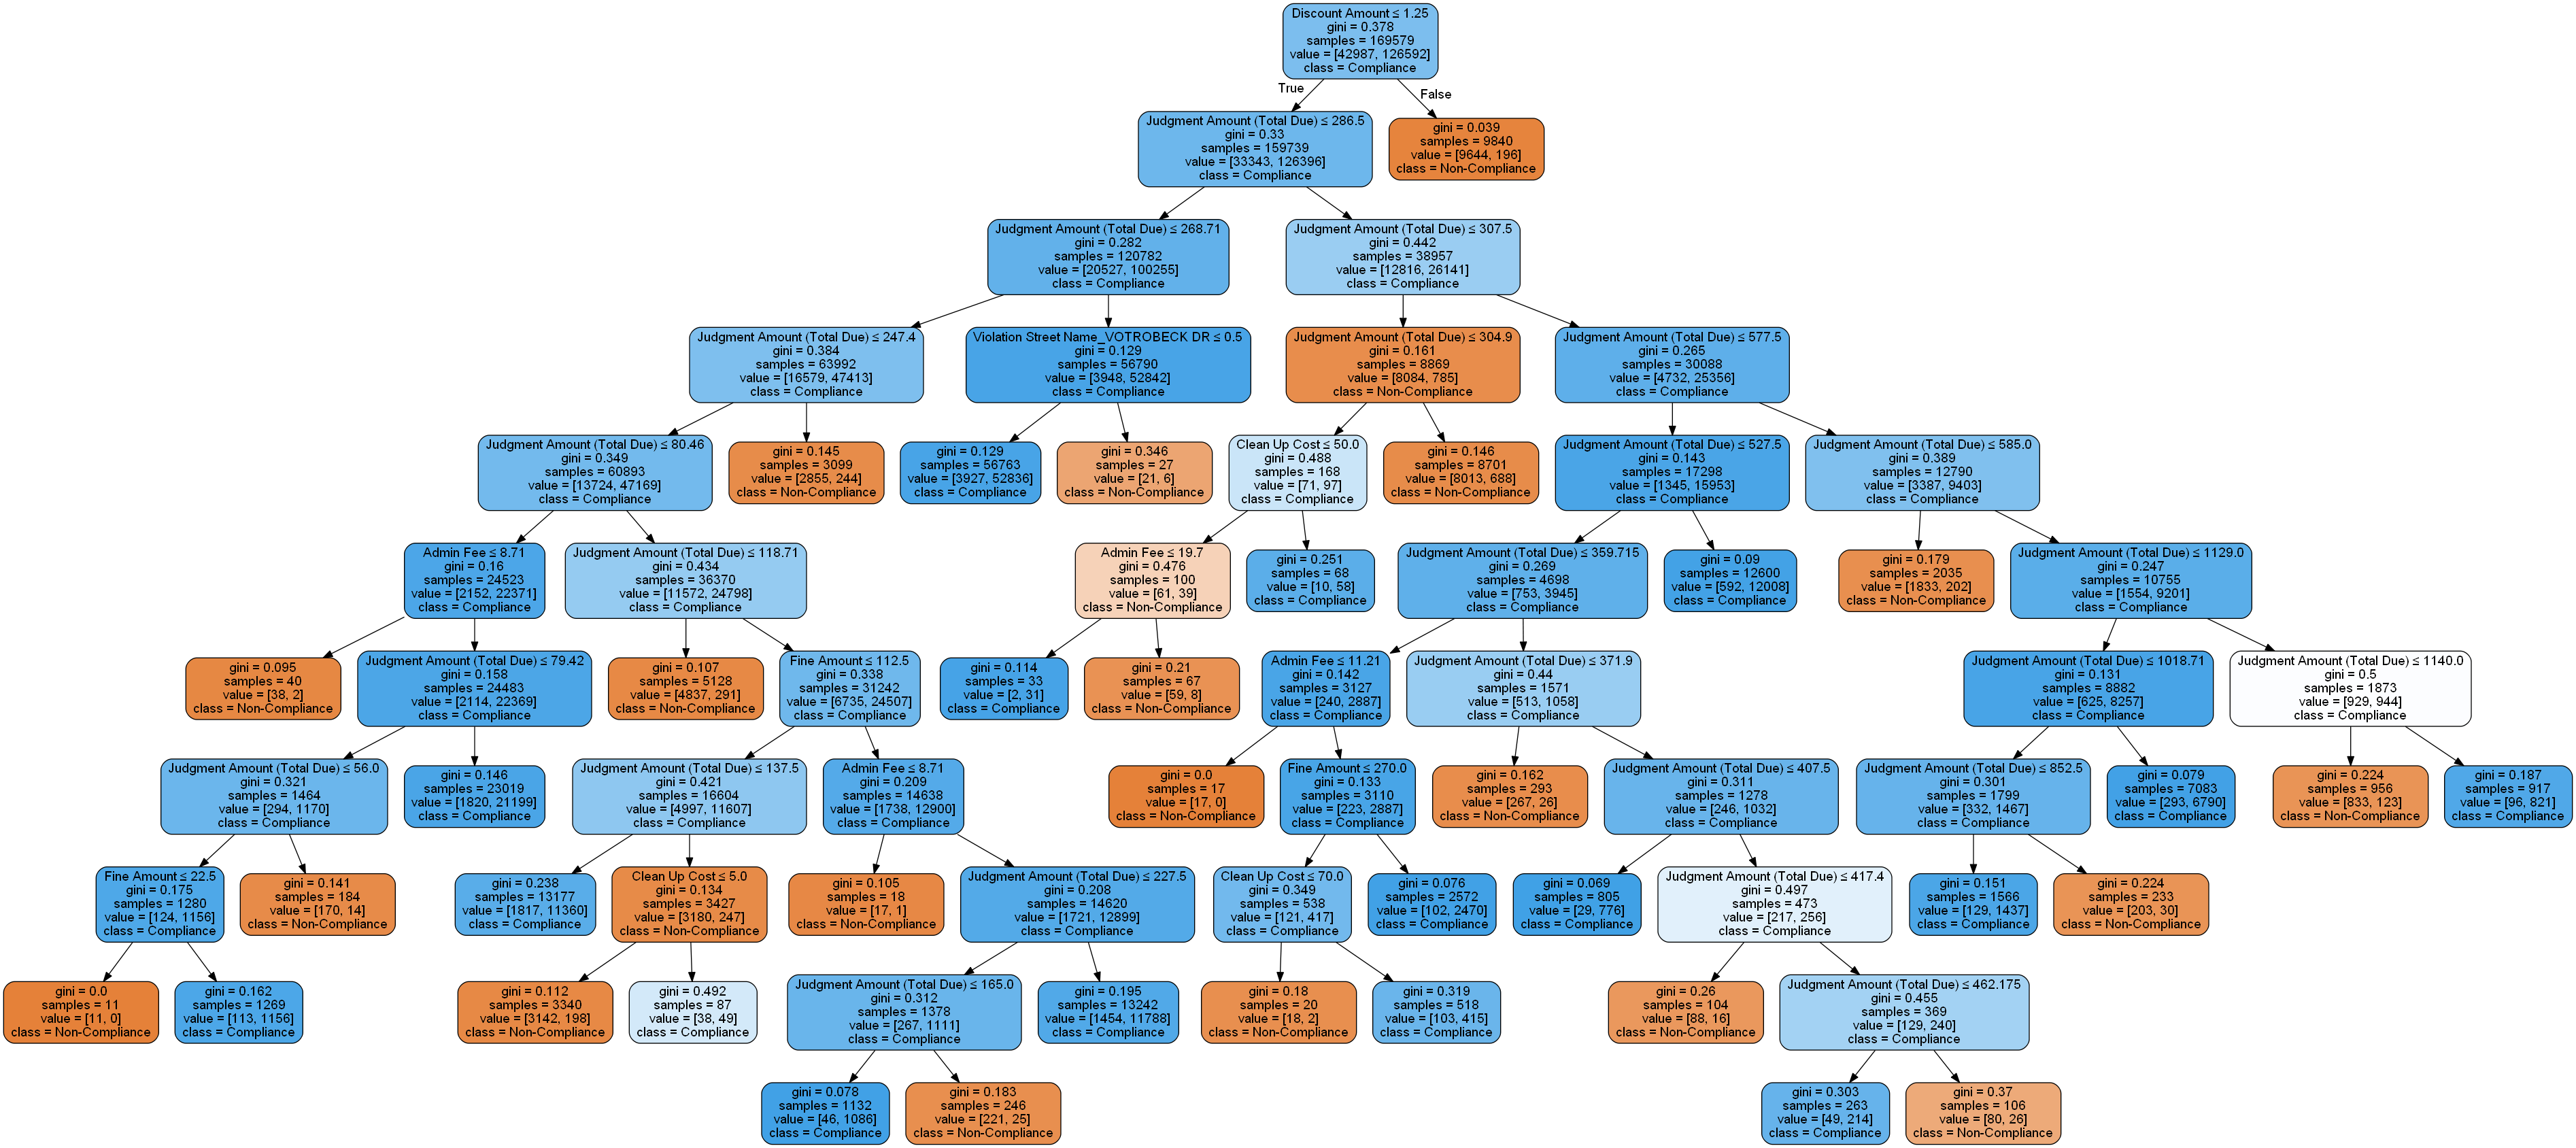

In [40]:
#Add visualizations of performance, data, etc.
#produce visualization of decision tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(DTClf, out_file=dot_data, filled=True, rounded=True,
                special_characters=True, feature_names=featureColumns, class_names=['Non-Compliance', 'Compliance'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png("Decision Tree.png")
graph.write_pdf('Decion Tree.pdf')
Image(graph.create_png())